In [1]:
# Let's start by creating a sample dataset.

import json
from dotenv import load_dotenv

# Load api keys from .env file
load_dotenv(override=True) 

"""
You can also create your own jsonl file where each line is in this format:
{
    "query": {
        "id": "q1",
        "query": "What is the capital of France?"
    },
    "documents": [
        {"id": "d1", "content": "Paris is the capital of France.", "score": 0.9},
        {"id": "d2", "content": "Rome is the capital of Italy.", "score": 0.8},
        ...
    ]
}

An example of such a file can be found at `./data/legalquad.jsonl`.
The scores are optional, if not provided, the score of the ith document will be set to 1 / (i + 1).
"""

# Here's an example of how to create such a dataset:
SOURCE_DATASET_PATH = "./data/my_sample_dataset.jsonl"
with open(SOURCE_DATASET_PATH, "w") as f:
    f.write(json.dumps(
        {
            "query": {
                "id": "q1",
                "query": "What is the capital of France?"
            },
            "documents": [
                # Oh no, we scored it high, but this document is not relevant to the query!
                {"id": "d1", "content": "Paris has a capital letter. France also has a capital letter.", "score": 0.9},
                # This is what we actually want
                {"id": "d2", "content": "Paris is the capital of France.", "score": 0.7},
                # This is definitely not relevant to the query
                {"id": "d3", "content": "Rome is the capital of Italy.", "score": 0.2},
            ]
        }
    ))

In [9]:
# At first, we need to Ensemble annotate the dataset.
# We can do this by running the following code:

from zbench.annotation import EnsembleZELOAnnotator

# We'll initialize an ELO annotator that will read from our example dataset, and output an annotated dataset.
ANNOTATED_DATASET_PATH = "./data/my_sample_dataset_zelo_annotated.jsonl"
annotator = EnsembleZELOAnnotator(SOURCE_DATASET_PATH, ANNOTATED_DATASET_PATH)

# Now, we'll run the ELO annotator. It will write to the jsonl file we specified in the constructor.
await annotator.zelo_annotate()

Step 1: Loading dataset
Loaded 1 queries from data/annotation/my_sample_dataset/dataset.jsonl
Step 2: Creating pairs for AI scoring


Creating pairs: 100%|██████████| 1/1 [00:00<00:00, 468.17it/s]


Created 12 pairs and saved to data/annotation/my_sample_dataset/pairs.json
Step 3: Scoring pairs


Scoring Pairs: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]

Scored 12 pairs and saved to data/annotation/my_sample_dataset/ai_scores.json
Step 4: Composing annotated dataset
Created 1 annotated lines
Saved annotated dataset to ./data/my_sample_dataset_zelo_annotated.jsonl

🎉 Annotation completed successfully!
Final outputs:
Annotated dataset: ./data/my_sample_dataset_zelo_annotated.jsonl


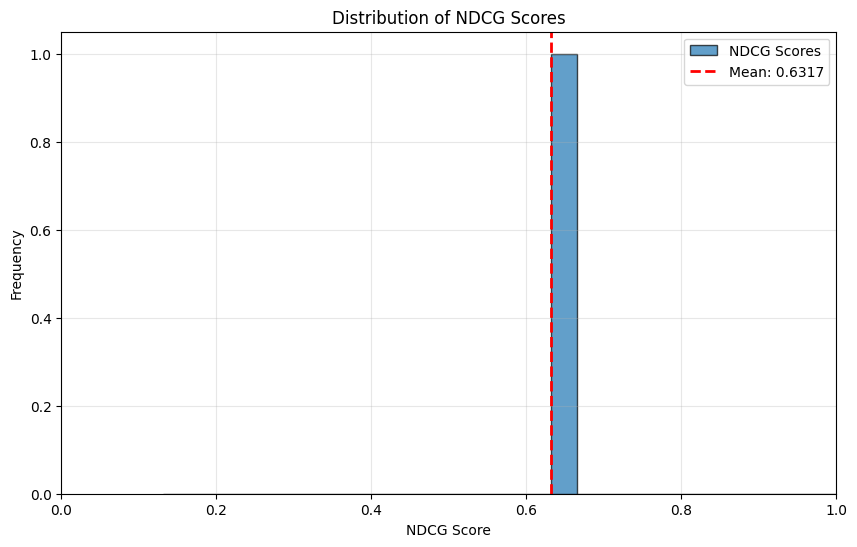

[np.float64(0.6316740659321393)]
[0.6666666666666666]
[0.6]


In [3]:
# Finally, we can run three benchmarks:

from zbench.benchmark import benchmark_ndcg, benchmark_accuracy, recall_at_k

# The NDCG/Recall scores are around ~0.66, because out of the three documents, the correct document was incorrectly in second place.
# If you use a dataset with hundreds of queries and many candidates documents per query, these graphs become very enlightening.
print(benchmark_ndcg(SOURCE_DATASET_PATH, ANNOTATED_DATASET_PATH, visualize=True))
print(benchmark_accuracy(SOURCE_DATASET_PATH, ANNOTATED_DATASET_PATH))
print(recall_at_k(SOURCE_DATASET_PATH, ANNOTATED_DATASET_PATH, 5))

# Testing Alternative Retrieval Methods

Any retrieval method can be tested, and compared to both the Ensemble annotations and the initial retrieval scores provided in the SOURCE_DATASET.

Note that since the candidate documents are already provided, we're always analyzing "rerankers" (Even if testing an bi-encoder embedding model, we're utilizing the embedding model as a reranker). If you would like to test alternative _initial retrieval_ methods, the suggestion would be to aggregate documents from multiple retrieval methods into the same SOURCE_DATASET candidate list. Then, you can zELO score all of the documents, and then analyze which initial retrieval method had the best zELO scores (With either NDCG, Recall, etc).

Below is an example of testing "zerank-1", ZeroEntropy's reranker. Other rerankers can be tested by implementing the BaseReranker abstract class.

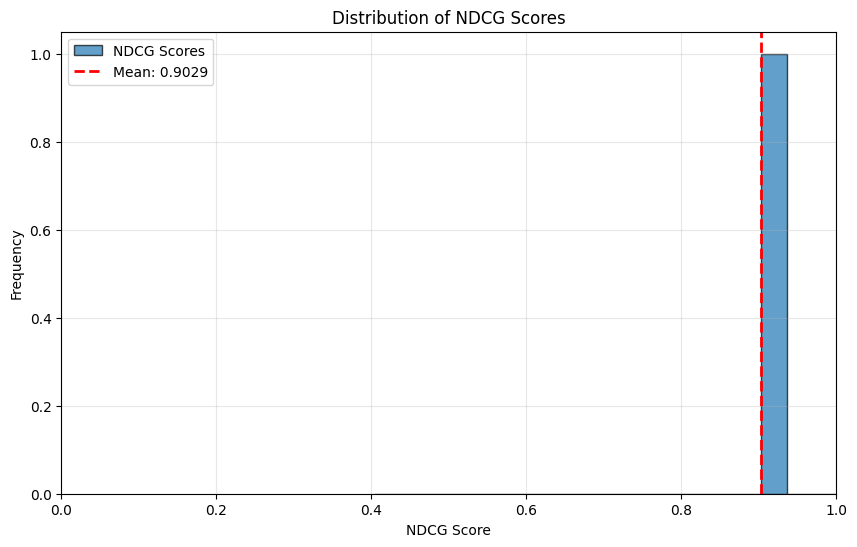

[np.float64(0.9028944580267518)]
[0.6666666666666666]
[0.0]


In [8]:
# You can also use built-in zerank reranker.
# This requires your ZEROENTROPY_API_KEY to be in the .env file.

from zbench.rerankers import Zerank

# Annotated the source dataset with ZeroEntropy's reranker: zerank-1
zerank = Zerank("zerank-1")
ZERANK_ANNOTATED_DATASET_PATH = "./data/my_sample_dataset_zerank_annotated.jsonl"
await zerank.annotate(SOURCE_DATASET_PATH, ZERANK_ANNOTATED_DATASET_PATH)

# This will now graph the performance of ZeroEntropy. It gets an NDCG > 90%, because it correctly identifies the correct ground truth document.
# A more complex dataset would show overall performance boost from our reranker.
print(benchmark_ndcg(SOURCE_DATASET_PATH, ZERANK_ANNOTATED_DATASET_PATH, visualize=True))
print(benchmark_accuracy(SOURCE_DATASET_PATH, ZERANK_ANNOTATED_DATASET_PATH))
print(recall_at_k(SOURCE_DATASET_PATH, ZERANK_ANNOTATED_DATASET_PATH, 1))

# Analyzing the Annotations

For a given query-document pair, it is helpful to analyze all of the pairwise comparisons that involved that document, so that we can analyze why it was given that zELO score. This can be used to debug and analyze failure modes in your current retrieval pipeline. If you disagree with the zELO score, the chain of thought can also be used to prompt engineer the Ensemble for your use-case.

Since we do 4 inferences per document, and each inference involves two documents, then each document is involved in ~8 pairwise comparisons on average.

In [ ]:
# Show all of the pairwise comparisons between query id "q1" and document id "d2".

from zbench.common_types import DatasetPairScoredPairs
from zbench.utils import load_json

# Load the AI scores
ai_scores = DatasetPairScoredPairs.model_validate(load_json("data/annotation/my_sample_dataset/ai_scores.json"))

# Find pairs involving d2 for query q1
target_query_id = "q1"
target_document_id = "d2"

print(f"QUERY: ({target_query_id}) What is the capital of France?")
print(f"\nDOCUMENT: ({target_document_id}) Paris is the capital of France.")
print(f"\nANNOTATIONS:")

for scored_pair in ai_scores.scored_pairs:
    pair = scored_pair.pair
    if pair.query_id == target_query_id:
        # Check if d2 is either document_a or document_b
        if pair.document_a.document_id == target_document_id:
            # d2 is document_a, so competing document is document_b
            competing_doc = pair.document_b
        elif pair.document_b.document_id == target_document_id:
            # d2 is document_b, so competing document is document_a
            competing_doc = pair.document_a
        else:
            continue  # This pair doesn't involve d2
        
        print(f"\n- Competing Document: ({competing_doc.document_id}) {competing_doc.content}")
        print("OpenAI Thoughts:")
        for line in scored_pair.openai_score.thought.split('\n'):
            if line.strip():
                print(f"    > {line.strip()}")
        print("Gemini Thoughts:")
        for line in scored_pair.gemini_score.thought.split('\n'):
            if line.strip():
                print(f"    > {line.strip()}")
        print("Claude Thoughts:")
        for line in scored_pair.anthropic_score.thought.split('\n'):
            if line.strip():
                print(f"    > {line.strip()}")


QUERY: (q1) What is the capital of France?

DOCUMENT: (d2) Paris is the capital of France.

ANNOTATIONS:

- Competing Document: (d3) Rome is the capital of Italy.
OpenAI Thoughts:
    > Document A directly answers the query by stating 'Paris is the capital of France.' This is a precise and correct response to the question.
    > There are no extraneous details or errors in Document A; it is concise and fully relevant.
    > Document B, on the other hand, discusses the capital of Italy, which is not relevant to the query about France.
    > While Document B is factually correct about Italy, it does not address the user's question at all.
Gemini Thoughts:
    > Document A directly and accurately answers the user's query. It states that Paris is the capital of France, which is precisely the information requested.
    > Document B provides a fact of the same type (capital of a country), but for a different country, Italy. This information is not relevant to the user's query about France.
 